In [283]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
# import plotly.express as px
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from xgboost import XGBClassifier

pd.options.display.max_columns=None
pd.options.display.max_rows=None

In [403]:
# load model_df data
model_df = pd.read_csv('model_df.csv')
print(model_df.shape)

(135599, 28)


In [404]:
model_df.dtypes

Unnamed: 0                      int64
loan_amnt                     float64
term                           object
int_rate                      float64
sub_grade                      object
emp_length                     object
home_ownership                 object
annual_inc                    float64
loan_status                     int64
purpose                        object
addr_state                     object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line               object
fico_range_high               float64
inq_last_6mths                float64
open_acc                      float64
pub_rec                       float64
revol_bal                     float64
revol_util                    float64
total_acc                     float64
acc_now_delinq                float64
delinq_amnt                   float64
collections_12_mths_ex_med    float64
application_type               object
year                          float64
profit      

In [406]:
model_df = model_df.loc[model_df['year']<2016]

model_df = model_df.drop(['Unnamed: 0','year','region','profit','earliest_cr_line'],axis=1)

le = LabelEncoder()
categorical_features = [feature for feature in model_df.columns if model_df[feature].dtypes == 'O']

for feature in categorical_features:
    model_df[feature]=le.fit_transform(model_df[feature])

In [331]:
model_df = model_df.drop(['Unnamed: 0','year','month','region','profit','earliest_cr_line','grade','fico_range_low','date'],axis=1)

le = LabelEncoder()
categorical_features = [feature for feature in model_df.columns if model_df[feature].dtypes == 'O']

for feature in categorical_features:
    model_df[feature]=le.fit_transform(model_df[feature])

In [409]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88272 entries, 0 to 122246
Data columns (total 23 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loan_amnt                   88272 non-null  float64
 1   term                        88272 non-null  int32  
 2   int_rate                    88272 non-null  float64
 3   sub_grade                   88272 non-null  int32  
 4   emp_length                  88272 non-null  int32  
 5   home_ownership              88272 non-null  int32  
 6   annual_inc                  88272 non-null  float64
 7   loan_status                 88272 non-null  int64  
 8   purpose                     88272 non-null  int32  
 9   addr_state                  88272 non-null  int32  
 10  dti                         88272 non-null  float64
 11  delinq_2yrs                 88272 non-null  float64
 12  fico_range_high             88272 non-null  float64
 13  inq_last_6mths              88

In [411]:
model_df['loan_status'].value_counts()

0    54226
1    34046
Name: loan_status, dtype: int64

In [412]:
model_df.head()

loan_amnt  term  int_rate  sub_grade  emp_length  home_ownership  \
0    10400.0     1     22.45          5           4               0   
1    18000.0     1     19.48          1           8               4   
2     8650.0     0     19.89          2           9               4   
3    24250.0     1     24.24          7           5               0   
4    15850.0     1     23.13          6           2               3   

   annual_inc  loan_status  purpose  addr_state    dti  delinq_2yrs  \
0    104433.0            0        6          38  25.37          1.0   
1    150000.0            1        2           4   9.39          0.0   
2     55000.0            0        2          15  25.49          0.0   
3     75000.0            1        2          34  20.84          0.0   
4     45000.0            0        2          35  34.85          0.0   

   fico_range_high  inq_last_6mths  open_acc  pub_rec  revol_bal  revol_util  \
0            699.0             3.0      12.0      0.0    21929.0        64.5   
1            669.0             1.0      18.0      1.0    14052.0        40.7   
2            679.0             4.0      18.0      1.0     9568.0        46.0   
3            664.0             0.0      18.0      0.0    24799.0        65.3   
4            759.0             1.0      18.0      0.0     8799.0        21.3   

   total_acc  acc_now_delinq  delinq_amnt  collections_12_mths_ex_med  \
0       35.0             0.0          0.0                         0.0   
1       27.0             0.0          0.0                         0.0   
2       19.0             0.0          0.0                         0.0   
3       21.0             0.0          0.0                         0.0   
4       24.0             0.0          0.0                         0.0   

   application_type  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

In [432]:
# Define function to print out model result

def print_result(model,dataset):
    if dataset == 'train':
        print(f'Train set score: {model.score(X_gb_train,y_gb_train)}')
        print('*'*40)
        print(f'Classification Report: \n {pd.DataFrame(classification_report(y_gb_train,model.predict(X_gb_train),output_dict=True))}')
        print('*'*40)
        print(f'Confusion Matrix: \n {confusion_matrix(y_gb_train,model.predict(X_gb_train))}')
    elif dataset == 'test':
        print(f'Test set score: {model.score(X_gb_test,y_gb_test)}')
        print('*'*40)
        print(f'Classification Report: \n {pd.DataFrame(classification_report(y_gb_test,model.predict(X_gb_test),output_dict=True))}')
        print('*'*40)
        print(f'Confusion Matrix: \n {confusion_matrix(y_gb_test,model.predict(X_gb_test))}')
    
def feature_importance(model,gs=True):
    if gs == False:
        feature_importance = list(zip(X_gb_train.columns, model.feature_importances_))
        dtype = [('feature', 'S10'), ('importance', 'float')]
        feature_importance = np.array(feature_importance, dtype=dtype)
        feature_sort = np.sort(feature_importance, order='importance')[::-1]
        name, score = zip(*list(feature_sort))
        print(pd.DataFrame(feature_sort[:20]))
        pd.DataFrame({'name':name,'score':score})[:20].plot.barh(x='name', y='score').invert_yaxis()
        plt.title('Feature Importance Plot')
    if gs == True:
        feature_importance = list(zip(X_gb_train.columns, model.best_estimator_.feature_importances_))
        dtype = [('feature', 'S10'), ('importance', 'float')]
        feature_importance = np.array(feature_importance, dtype=dtype)
        feature_sort = np.sort(feature_importance, order='importance')[::-1]
        name, score = zip(*list(feature_sort))
        print(pd.DataFrame(feature_sort[:20]))
        pd.DataFrame({'name':name,'score':score})[:20].plot.barh(x='name', y='score').invert_yaxis()
        plt.title('Feature Importance Plot')

In [410]:
# Train test split on the dataset

X_gb_feature = model_df.drop('loan_status',axis=1)
y_gb_target = model_df['loan_status']
X_gb_train, X_gb_test, y_gb_train, y_gb_test = train_test_split(X_gb_feature,y_gb_target)


D:\software\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Wall time: 1min 46s
Train set score: 0.7198054498217631
****************************************
Classification Report: 
                       0             1  accuracy     macro avg  weighted avg
precision      0.711213      0.752543  0.719805      0.731878      0.727133
recall         0.916319      0.406164  0.719805      0.661241      0.719805
f1-score       0.800842      0.527581  0.719805      0.664211      0.695581
support    40702.000000  25502.000000  0.719805  66204.000000  66204.000000
****************************************
Confusion Matrix: 
 [[37296  3406]
 [15144 10358]]
Test set score: 0.6350371578756571
****************************************
Classification Report: 
                       0            1  accuracy     macro avg  weighted avg
precision      0.654625     0.555936  0.635037      0.605280      0.616416
recall         0.856182     0.284995  0.635037      0.570588      0.635037
f1-score       0.741958     0.376818  0.635037      0.559388      0.600588
suppo

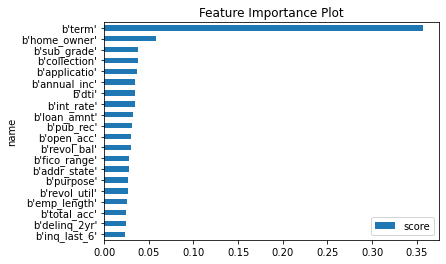

In [433]:
# XGBoost model on E, F, and G loan grade
gb_model = XGBClassifier(n_estimators = 3000, learning_rate=0.01)
%time gb_model.fit(X_gb_train,y_gb_train)

print_result(gb_model,'train')
print_result(gb_model,'test')

feature_importance(gb_model,False)

In [ ]:
# Random Forest model on E, F, and G loan grade
rf_model = RandomForestClassifier(class_weight="balanced")
params = {'n_estimators':range(20,101,20), 'max_depth':range(10,31,10), 'max_features':range(1,5), \
          'min_samples_leaf':range(1,5), 'min_samples_split':range(2,5)}
gs_rf_model = GridSearchCV(rf_model, params, cv=3, iid=True, return_train_score=True,verbose=0)
%time rf_model.fit(X_gb_train,y_gb_train)
%time gs_rf_model.fit(X_gb_train,y_gb_train)


print_result(rf_model,'train')
print_result(rf_model,'test')
feature_importance(rf_model,False)
print(f'Train set score: {gs_rf_model.best_estimator_.score(X_gb_train,y_gb_train)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_gb_train,gs_rf_model.best_estimator_.predict(X_gb_train),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_gb_train,gs_rf_model.best_estimator_.predict(X_gb_train))}')
print(f'Test set score: {gs_rf_model.best_estimator_.score(X_gb_test,y_gb_test)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_gb_test,gs_rf_model.best_estimator_.predict(X_gb_test),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_gb_test,gs_rf_model.best_estimator_.predict(X_gb_test))}')
feature_importance(gs_rf_model,True)

print(gs_rf_model.best_params_)

# feature_importance_gs(gs_rf_model)

# print(rf_model.score(X_gb_train,y_gb_train))
# print(rf_model.score(X_gb_test,y_gb_test))
# print(confusion_matrix(y_gb_train,rf_model.predict(X_gb_train)))
# print(confusion_matrix(y_gb_test,rf_model.predict(X_gb_test)))

In [ ]:
# examine the cross validation train and test score with different hypeparameters

gs_score = pd.DataFrame(gs_rf_efg.cv_results_)[['param_max_depth','param_max_features','param_min_samples_leaf',\
                                      'param_min_samples_split','param_n_estimators','mean_test_score','mean_train_score']]
sns.scatterplot(x=gs_score['mean_train_score'], y = gs_score['mean_test_score'], data=gs_score)

In [ ]:
# temp = gs_score[gs_score['mean_train_score']<0.7]
# sns.scatterplot(x=temp['mean_train_score'], y=temp['mean_test_score'], data=temp)

In [340]:
# try Deep Learning moodel

from tensorflow import keras
from sklearn.preprocessing import scale

model = keras.Sequential(
    [
        keras.layers.Dense(
            150, activation="relu", input_shape=(X_gb_train.shape[-1],)
        ),
        keras.layers.Dense(150, activation = "relu"),
        #keras.layers.Dropout(0.3),
       keras.layers.Dense(150, activation="relu"),
        # keras.layers.Dropout(0.3),
        keras.layers.Dense(150, activation="relu"),\
        #keras.layers.Dense(20, activation="relu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 150)               3600      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_3 (Dense)              (None, 150)               22650     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 151       
Total params: 71,701
Trainable params: 71,701
Non-trainable params: 0
_________________________________________________________________


In [343]:
%%time

metrics = [
   keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold = 0.97
)
]

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20,
    decay_rate=0.9)

model.compile(
    optimizer=keras.optimizers.SGD(lr_schedule), loss="binary_crossentropy", metrics = metrics
)

callbacks = [keras.callbacks.ModelCheckpoint("Default_loans_model_at_epoch_{epoch}.h5")]


model.fit(
    X_gb_train,
    y_gb_train,
    batch_size = 10,
    epochs = 3,
    verbose = 2,
    callbacks=callbacks,
    validation_data=(X_gb_test, y_gb_test),
    validation_split = 0.2,
    validation_freq = 1,
    shuffle = True,
    class_weight = {0:0.65, 1:2},

)

Epoch 1/3
8136/8136 - 15s - loss: nan - binary_accuracy: 0.5920 - val_loss: nan - val_binary_accuracy: 0.5938
Epoch 2/3
8136/8136 - 9s - loss: nan - binary_accuracy: 0.5921 - val_loss: nan - val_binary_accuracy: 0.5938
Epoch 3/3
8136/8136 - 8s - loss: nan - binary_accuracy: 0.5921 - val_loss: nan - val_binary_accuracy: 0.5938
Wall time: 57.4 s


In [351]:
%%time
print("-"*100)
print("Training")
print(confusion_matrix(y_true = y_gb_train, y_pred = model.predict_classes(X_gb_train)))
print("-"*100)
print("Validation")
print(confusion_matrix(y_true = y_gb_test, y_pred = model.predict_classes(X_gb_test)))
print("-"*100)

----------------------------------------------------------------------------------------------------
Training
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[[60253     0]
 [41446     0]]
----------------------------------------------------------------------------------------------------
Validation
[[20014     0]
 [13886     0]]
----------------------------------------------------------------------------------------------------
Wall time: 37.2 s


In [ ]:
accepted = pd.read_csv('accepted_2007_to_2018Q4.csv.gz')
print(accepted.shape)

In [ ]:
model_df = accepted[['grade','loan_status','region','annual_inc','application_type','dti','earliest_cr_line','term',\
                     'fico_range_high','loan_amnt','home_ownership','sub_grade','installment','int_rate','open_acc',\
                     'pub_rec','initial_list_status','purpose','pub_rec_bankruptcies','total_acc','revol_bal','revol_util',\
                     'delinq_amnt','verification_status','delinq_2yrs','inq_last_6mths','acc_now_delinq']]

model_df_e = model_df[model_df['grade']=='E']
model_df_f = model_df[model_df['grade']=='F']
model_df_g = model_df[model_df['grade']=='G']

le = LabelEncoder()
categorical_features_e = [feature_e for feature_e in model_df_e.columns if model_df_e[feature_e].dtypes == 'O']
for feature_e in categorical_features_e:
    model_df_e[feature_e]=le.fit_transform(model_df_e[feature_e])
categorical_features_f = [feature_f for feature_f in model_df_f.columns if model_df_f[feature_f].dtypes == 'O']
for feature_f in categorical_features_f:
    model_df_f[feature_f]=le.fit_transform(model_df_f[feature_f])
categorical_features_g = [feature_g for feature_g in model_df_g.columns if model_df_g[feature_g].dtypes == 'O']
for feature_g in categorical_features_g:
    model_df_g[feature_g]=le.fit_transform(model_df_g[feature_g])

model_df_e_feature = model_df_e.drop('loan_status',axis=1)
model_df_e_target = model_df_e['loan_status']

model_df_f_feature = model_df_f.drop('loan_status',axis=1)
model_df_f_target = model_df_f['loan_status']

model_df_g_feature = model_df_g.drop('loan_status',axis=1)
model_df_g_target = model_df_g['loan_status']

X_e_train, X_e_test, y_e_train, y_e_test = train_test_split(model_df_e_feature, model_df_e_target,test_size= 0.2)

X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(model_df_f_feature, model_df_f_target,test_size= 0.2)

X_g_train, X_g_test, y_g_train, y_g_test = train_test_split(model_df_g_feature, model_df_g_target,test_size= 0.2)



In [ ]:
# Random Forest model on E loan grade
rf_e_model = RandomForestClassifier(class_weight="balanced")
params = {'n_estimators':range(20,101,20), 'max_depth':range(10,31,10), 'max_features':range(1,5), \
          'min_samples_leaf':range(1,5), 'min_samples_split':range(2,5)}
gs_rf_e_model = GridSearchCV(rf_e_model, params, cv=3, iid=True, return_train_score=True,verbose=0)
%time rf_e_model.fit(X_e_train,y_e_train)
%time gs_rf_e_model.fit(X_e_train,y_e_train)


print_result(rf_e_model,'train')
print_result(rf_e_model,'test')
print_result(gs_rf_e_model,'train')
print_result(gs_rf_e_model,'test')
feature_importance(rf_e_model,False)
feature_importance(gs_rf_e_model,True)

In [ ]:
# XGBoost model on E loan grade
gb_e_model = XGBClassifier(n_estimators = 3000, learning_rate=0.01)
%time gb_e_model.fit(X_e_train,y_e_train)

print(f'Train set score: {gb_e_model.score(X_e_train,y_e_train)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_e_train,gb_e_model.predict(X_e_train),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_e_train,gb_e_model.predict(X_e_train))}')
print(f'Test set score: {gb_e_model.score(X_e_test,y_e_test)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_e_test,gb_e_model.predict(X_e_test),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_e_test,gb_e_model.predict(X_e_test))}')

feature_importance(gb_e_model,False)

In [ ]:
# Random Forest model on F loan grade
rf_f_model = RandomForestClassifier(class_weight="balanced")
params = {'n_estimators':range(20,101,20), 'max_depth':range(10,31,10), 'max_features':range(1,5), \
          'min_samples_leaf':range(1,5), 'min_samples_split':range(2,5)}
gs_rf_f_model = GridSearchCV(rf_f_model, params, cv=3, iid=True, return_train_score=True,verbose=0)
%time rf_f_model.fit(X_f_train,y_f_train)
%time gs_rf_f_model.fit(X_f_train,y_f_train)


print_result(rf_f_model,'train')
print_result(rf_f_model,'test')
print_result(gs_rf_f_model,'train')
print_result(gs_rf_f_model,'test')
feature_importance(rf_f_model,False)
feature_importance(gs_rf_f_model,True)

In [ ]:
# XGBoost model on F loan grade
gb_f_model = XGBClassifier(n_estimators = 3000, learning_rate=0.01)
%time gb_f_model.fit(X_gb_train,y_gb_train)

print(f'Train set score: {gb_f_model.score(X_f_train,y_f_train)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_f_train,gb_f_model.predict(X_f_train),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_f_train,gb_f_model.predict(X_f_train))}')
print(f'Test set score: {gb_f_model.score(X_f_test,y_f_test)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_f_test,gb_f_model.predict(X_f_test),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_f_test,gb_f_model.predict(X_f_test))}')

feature_importance(gb_f_model,False)

In [ ]:
# Random Forest model on G loan grade
rf_g_model = RandomForestClassifier(class_weight="balanced")
params = {'n_estimators':range(20,101,20), 'max_depth':range(10,31,10), 'max_features':range(1,5), \
          'min_samples_leaf':range(1,5), 'min_samples_split':range(2,5)}
gs_rf_g_model = GridSearchCV(rf_g_model, params, cv=3, iid=True, return_train_score=True,verbose=0)
%time rf_g_model.fit(X_g_train,y_g_train)
%time gs_rf_g_model.fit(X_g_train,y_g_train)


print_result(rf_g_model,'train')
print_result(rf_g_model,'test')
print_result(gs_rf_g_model,'train')
print_result(gs_rf_g_model,'test')
feature_importance(rf_g_model,False)
feature_importance(gs_rf_g_model,True)

In [ ]:
# XGBoost model on G loan grade
gb_g_model = XGBClassifier(n_estimators = 3000, learning_rate=0.01)
%time gb_g_model.fit(X_gb_train,y_gb_train)

print(f'Train set score: {gb_g_model.score(X_g_train,y_g_train)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_g_train,gb_g_model.predict(X_g_train),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_g_train,gb_g_model.predict(X_g_train))}')
print(f'Test set score: {gb_g_model.score(X_g_test,y_g_test)}')
print('*'*40)
print(f'Classification Report: \n {pd.DataFrame(classification_report(y_g_test,gb_g_model.predict(X_g_test),output_dict=True))}')
print('*'*40)
print(f'Confusion Matrix: \n {confusion_matrix(y_g_test,gb_g_model.predict(X_g_test))}')

feature_importance(gb_g_model,False)

In [307]:
print_result(rf_model,test)

Test set score: 0.9642182890855457
****************************************
                      0             1  accuracy     macro avg  weighted avg
precision      0.948135      0.992250  0.964926      0.970193      0.966213
recall         0.995002      0.921610  0.964926      0.958306      0.964926
f1-score       0.971004      0.955626  0.964926      0.963315      0.964702
support    20008.000000  13892.000000  0.964926  33900.000000  33900.000000
****************************************
[[19908   100]
 [ 1089 12803]]


In [303]:
model_df_efg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135823 entries, 4 to 2260519
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_status           135823 non-null  int32  
 1   region                135823 non-null  int32  
 2   annual_inc            135823 non-null  float64
 3   application_type      135823 non-null  int32  
 4   dti                   135823 non-null  float64
 5   earliest_cr_line      135823 non-null  float64
 6   term                  135823 non-null  int32  
 7   fico_range_high       135823 non-null  float64
 8   fico_range_low        135823 non-null  float64
 9   funded_amnt           135823 non-null  float64
 10  home_ownership        135823 non-null  int32  
 11  sub_grade             135823 non-null  int32  
 12  installment           135823 non-null  float64
 13  int_rate              135823 non-null  float64
 14  open_acc              135823 non-null  float64
 15 

In [125]:
# Random Forest Model on E, F, and G
model_df_efg = model_df[(model_df['grade'] == 'E') | (model_df['grade'] == 'F') | (model_df['grade'] == 'G')]

# print(model_df_efg[model_df_efg['loan_status']==0].shape)
# print(model_df_efg[model_df_efg['loan_status']==1].shape)

model_df_efg = model_df_efg[['loan_status','region','annual_inc','application_type','dti','earliest_cr_line','term',\
                               'fico_range_high','fico_range_low','funded_amnt','home_ownership','sub_grade',\
                               'installment','int_rate','open_acc','pub_rec','initial_list_status','purpose',\
                               'pub_rec_bankruptcies','total_acc','revol_bal','revol_util','delinq_amnt','verification_status',\
                               'delinq_2yrs']]

# model_df_efg['mths_since_last_delinq'] = model_df_efg['mths_since_last_delinq'].fillna(0)
# model_df_efg['mths_since_last_major_derog'] = model_df_efg['mths_since_last_major_derog'].fillna(0)
model_df_efg['revol_util'] = model_df_efg['revol_util'].fillna(0)
model_df_efg['pub_rec_bankruptcies'] = model_df_efg['pub_rec_bankruptcies'].fillna(0)
model_df_efg['dti'] = model_df_efg['dti'].fillna(0)
model_df_efg.dropna(how = 'any', subset=['open_acc'],inplace=True)
# model_df_efg.dropna(inplace = True)
model_df_efg['earliest_cr_line'] = model_df_efg['earliest_cr_line'].str.split('-',expand=True)[1].astype(float)
# # model_df_efg['emp_length'] = model_df_efg['emp_length'].astype(float)
# model_df_efg['loan_status'] = model_df_efg['loan_status'].astype(float)
model_df_efg = model_df_efg.drop('fico_range_low',axis=1)

le = LabelEncoder()
categorical_features = [feature for feature in model_df_efg.columns if model_df_efg[feature].dtypes == 'O']
for feature in categorical_features:
    model_df_efg[feature] = le.fit_transform(model_df_efg[feature])
    
model_df_efg_feature = model_df_efg.drop('loan_status',axis=1)
model_df_efg_target = model_df_efg['loan_status']


X_efg_train, X_efg_test, y_efg_train, y_efg_test = train_test_split(model_df_efg_feature, model_df_efg_target,test_size= 0.2)

# normalize data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# X_efg_train = scaler.fit_transform(X_efg_train)
# X_efg_test = scaler.transform(X_efg_test)


rf_efg = RandomForestClassifier(class_weight="balanced")

# rf_efg = RandomForestClassifier(n_estimators=100, class_weight="balanced", n_jobs=-1)
params = {'n_estimators':range(20,101,20), 'max_depth':range(10,31,10), 'max_features':range(1,5), \
          'min_samples_leaf':range(1,5), 'min_samples_split':range(2,5)}
gs_rf_efg = GridSearchCV(rf_efg, params, cv=3, iid=True, return_train_score=True,verbose=0)
%time gs_rf_efg.fit(X_efg_train,y_efg_train)
rf_efg.fit(X_efg_train,y_efg_train)

y_efg_train_pred = rf_efg.predict(X_efg_train)
y_efg_test_pred = rf_efg.predict(X_efg_test)
y_efg_gs_train_pred = gs_rf_efg.predict(X_efg_train)
y_efg_gs_test_pred = gs_rf_efg.predict(X_efg_test)
print('Original model')
print('*'*40)
print(rf_efg.score(X_efg_train,y_efg_train))
print(rf_efg.score(X_efg_test,y_efg_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_efg_train,y_efg_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_efg_test,y_efg_test_pred)}')
print('Grid Search model')
print('*'*40)
print(gs_rf_efg.best_params_)
print('*'*40)
print(gs_rf_efg.best_estimator_.score(X_efg_train,y_efg_train))
print(gs_rf_efg.best_estimator_.score(X_efg_test,y_efg_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_efg_train,y_efg_gs_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_efg_test,y_efg_gs_test_pred)}')

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 3h 49min 5s
Original model
****************************************
1.0
0.6036075832873182
****************************************
Train Set Confusion Matrix: 
 [[64398     0]
 [    0 44260]]
Test Set Confusion Matrix: 
 [[13467  2542]
 [ 8226  2930]]
Grid Search model
****************************************
{'max_depth': 30, 'max_features': 3, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 100}
****************************************
0.999567450164737
0.6078409718387631
****************************************
Train Set Confusion Matrix: 
 [[64387    11]
 [   36 44224]]
Test Set Confusion Matrix: 
 [[12502  3507]
 [ 7146  4010]]


         feature  importance
0         b'dti'    0.090384
1   b'revol_bal'    0.082453
2  b'installmen'    0.080507
3  b'revol_util'    0.079150
4  b'annual_inc'    0.076906
5  b'funded_amn'    0.070240
6    b'int_rate'    0.069220
7   b'total_acc'    0.065818
8  b'earliest_c'    0.059927
9    b'open_acc'    0.055196


Text(0.5, 1.0, 'Feature Importance Plot')

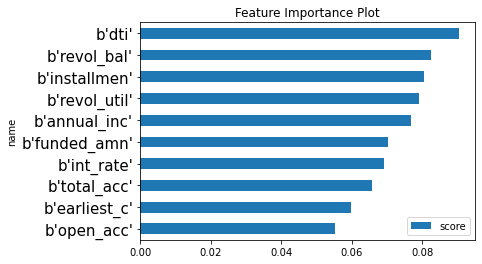

In [402]:
# gs_rf_efg.best_estimator_.feature_importances_
feature_importance_forest = list(zip(X_efg_train.columns, gs_rf_efg.best_estimator_.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance_forest = np.array(feature_importance_forest, dtype=dtype)
feature_sort_forest = np.sort(feature_importance_forest, order='importance')[::-1]
name, score = zip(*list(feature_sort_forest))
print(pd.DataFrame(feature_sort_forest[:10]))
pd.DataFrame({'name':name,'score':score})[:10].plot.barh(x='name', y='score').invert_yaxis()
plt.yticks(fontsize = 15)
plt.title('Feature Importance Plot')

<AxesSubplot:xlabel='mean_train_score', ylabel='mean_test_score'>

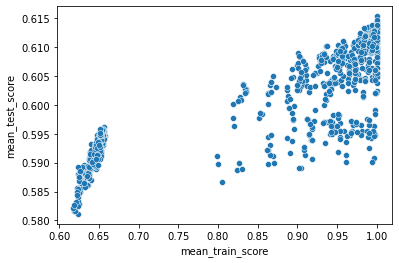

In [173]:
gs_score = pd.DataFrame(gs_rf_efg.cv_results_)[['param_max_depth','param_max_features','param_min_samples_leaf',\
                                      'param_min_samples_split','param_n_estimators','mean_test_score','mean_train_score']]
sns.scatterplot(x=gs_score['mean_train_score'], y = gs_score['mean_test_score'], data=gs_score)

<AxesSubplot:xlabel='mean_train_score', ylabel='mean_test_score'>

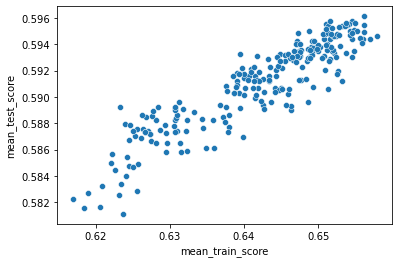

In [192]:
temp = gs_score[gs_score['mean_train_score']<0.7]
sns.scatterplot(x=temp['mean_train_score'], y=temp['mean_test_score'], data=temp)

In [253]:
import pickle

with open('pickled_rf_efg.pkl','wb') as fid:
    pickle.dump(gs_rf_efg, fid)

In [254]:
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_efg_train,y_efg_gs_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_efg_test,y_efg_gs_test_pred)}')

Train Set Confusion Matrix: 
 [[64387    11]
 [   36 44224]]
Test Set Confusion Matrix: 
 [[12502  3507]
 [ 7146  4010]]


In [268]:
threshold = 0.45

predicted_train = gs_rf_efg.predict_proba(X_efg_train)
predicted_test = gs_rf_efg.predict_proba(X_efg_test)
predicted_xtrain =  (predicted_train[:,1]>=threshold).astype('int')
predicted_xtest =  (predicted_test[:,1]>=threshold).astype('int')

# unique_train, counts_train = np.unique(gs_rf_efg.predict(X_efg_train),return_counts=True)
# unique_test, counts_test = np.unique(gs_rf_efg.predict(X_efg_test),return_counts=True)
# unique, counts = np.unique(predicted_xtrain,return_counts=True)
# unique1, counts1 = np.unique(predicted_xtest,return_counts=True)
# print(np.asarray((unique_train, counts_train)).T)
# print(np.asarray((unique_test, counts_test)).T)
# print(np.asarray((unique, counts)).T)
# print(np.asarray((unique1, counts1)).T)
# print(gs_rf_efg.predict_proba(X_efg_train))
# print(gs_rf_efg.predict(X_efg_train))

In [274]:
threshold = np.linspace(0.4,0.5,20)
for threshold in threshold:
    predicted_train = gs_rf_efg.predict_proba(X_efg_train)
    predicted_test = gs_rf_efg.predict_proba(X_efg_test)
    predicted_xtrain =  (predicted_train[:,1]>=threshold).astype('int')
    predicted_xtest =  (predicted_test[:,1]>=threshold).astype('int')
    print(f'threshold: {threshold}')
    print(confusion_matrix(y_efg_test,pd.Series(predicted_xtest)))
    print(pd.DataFrame(classification_report(y_efg_test,pd.Series(predicted_xtest),output_dict=True)))

threshold: 0.4
[[7498 8511]
 [3375 7781]]
                      0             1  accuracy     macro avg  weighted avg
precision      0.689598      0.477596  0.562452      0.583597      0.602534
recall         0.468362      0.697472  0.562452      0.582917      0.562452
f1-score       0.557845      0.566963  0.562452      0.562404      0.561590
support    16009.000000  11156.000000  0.562452  27165.000000  27165.000000
threshold: 0.4052631578947369
[[7807 8202]
 [3570 7586]]
                      0             1  accuracy     macro avg  weighted avg
precision      0.686209      0.480492  0.566648      0.583350      0.601726
recall         0.487663      0.679993  0.566648      0.583828      0.566648
f1-score       0.570145      0.563094  0.566648      0.566620      0.567249
support    16009.000000  11156.000000  0.566648  27165.000000  27165.000000
threshold: 0.4105263157894737
[[8094 7915]
 [3766 7390]]
                      0             1  accuracy     macro avg  weighted avg
precisio

threshold: 0.5
[[12502  3507]
 [ 7146  4010]]
                      0             1  accuracy     macro avg  weighted avg
precision      0.636299      0.533457  0.607841      0.584878      0.594064
recall         0.780936      0.359448  0.607841      0.570192      0.607841
f1-score       0.701237      0.429497  0.607841      0.565367      0.589640
support    16009.000000  11156.000000  0.607841  27165.000000  27165.000000


In [282]:
model_df_efg_base = model_df_efg[['loan_status','term','annual_inc']]
model_df_efg_base
model_df_efg_base_feature = model_df_efg_base.drop('loan_status',axis=1)
model_df_efg_base_target = model_df_efg_base['loan_status']

X_efg_base_train, X_efg_base_test, y_efg_base_train, y_efg_base_test = train_test_split(model_df_efg_base_feature, model_df_efg_base_target,\
                                                                                        test_size= 0.2)
rf_efg_base = RandomForestClassifier(class_weight="balanced")
rf_efg_base.fit(X_efg_base_train,y_efg_base_train)
print(rf_efg_base.score(X_efg_base_train,y_efg_base_train))
print(rf_efg_base.score(X_efg_base_test,y_efg_base_test))

print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_efg_base_train,rf_efg_base.predict(X_efg_base_train))}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_efg_base_test,rf_efg_base.predict(X_efg_base_test))}')

0.6054869406762503
0.5429412847413951
Train Set Confusion Matrix: 
 [[37190 27326]
 [15541 28601]]
Test Set Confusion Matrix: 
 [[8287 7604]
 [4812 6462]]


In [352]:
# XGBoost model

xgb_df_efg = model_df[(model_df['grade'] == 'E') | (model_df['grade'] == 'F') | (model_df['grade'] == 'G')]
xgb_df_efg = xgb_df_efg[['loan_status','region','annual_inc','application_type','dti','earliest_cr_line','term',\
                         'fico_range_high','fico_range_low','loan_amnt','home_ownership','sub_grade','year',\
                         'installment','int_rate','open_acc','pub_rec','initial_list_status','purpose',\
                         'pub_rec_bankruptcies','total_acc','revol_bal','revol_util','delinq_amnt','verification_status',\
                         'delinq_2yrs','inq_last_6mths','acc_now_delinq']]
xgb_df_efg = xgb_df_efg[xgb_df_efg['year']<2015]
xgb_df_efg = xgb_df_efg.drop(['earliest_cr_line','fico_range_low','year'],axis=1)

le = LabelEncoder()
categorical_features = [feature for feature in xgb_df_efg.columns if xgb_df_efg[feature].dtypes == 'O']

for feature in categorical_features:
    xgb_df_efg[feature]=le.fit_transform(xgb_df_efg[feature])

xgb_df_efg_feature = xgb_df_efg.drop('loan_status',axis=1)
xgb_df_efg_target = xgb_df_efg['loan_status']

X_xgb_efg_train, X_xgb_efg_test, y_xgb_efg_train, y_xgb_efg_test = train_test_split(xgb_df_efg_feature, xgb_df_efg_target,test_size= 0.2)

xgb_efg = XGBClassifier(n_estimator=50000,learning_rate=0.01)
xgb_efg.fit(X_xgb_efg_train,y_xgb_efg_train)
params = {'max_depth':range(2,10), 'min_child_weight':range(1,11),\
          'learning_rate':[0.001,0.01,0.1,0.5,1],'use_label_encoder': False}
gs_xgb_efg = GridSearchCV(xgb_efg, params, cv=5, iid=True, return_train_score=True)
%time gs_xgb_efg.fit(X_xgb_efg_train,y_xgb_efg_train)


y_xgb_efg_train_pred = xgb_efg.predict(X_xgb_efg_train)
y_xgb_efg_test_pred = xgb_efg.predict(X_xgb_efg_test)
y_xgb_efg_gs_train_pred = gs_xgb_efg.predict(X_xgb_efg_train)
y_xgb_efg_gs_test_pred = gs_xgb_efg.predict(X_xgb_efg_test)
print('Original model')
print('*'*40)
print(xgb_efg.score(X_xgb_efg_train,y_xgb_efg_train))
print(xgb_efg.score(X_xgb_efg_test,y_xgb_efg_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_xgb_efg_train,y_xgb_efg_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_xgb_efg_test,y_xgb_efg_test_pred)}')
print('Grid Search model')
print('*'*40)
print(gs_xgb_efg.best_params_)
print('*'*40)
print(gs_xgb_efg.best_estimator_.score(X_xgb_efg_train,y_xgb_efg_train))
print(gs_xgb_efg.best_estimator_.score(X_xgb_efg_test,y_xgb_efg_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_xgb_efg_train,y_xgb_efg_gs_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_xgb_efg_test,y_xgb_efg_gs_test_pred)}')



KeyError: 'grade'

In [184]:
print(xgb_efg.score(X_xgb_efg_train,y_xgb_efg_train))
print(xgb_efg.score(X_xgb_efg_test,y_xgb_efg_test))

print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_xgb_efg_train,xgb_efg.predict(X_xgb_efg_train))}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_xgb_efg_test,xgb_efg.predict(X_xgb_efg_test))}')

0.6658293350749831
0.6618105093941525
Train Set Confusion Matrix: 
 [[26083   182]
 [13121   423]]
Test Set Confusion Matrix: 
 [[6516   65]
 [3301   71]]


         feature  importance
0        b'term'    0.536796
1  b'annual_inc'    0.055829
2   b'sub_grade'    0.030980
3         b'dti'    0.030875
4  b'installmen'    0.029512
5  b'initial_li'    0.029191
6  b'home_owner'    0.028652
7   b'loan_amnt'    0.028296
8    b'int_rate'    0.024385
9    b'open_acc'    0.024210


Text(0.5, 1.0, 'Feature Importance Plot')

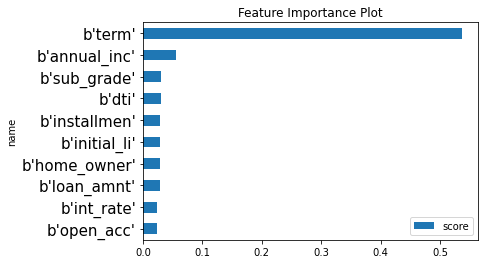

In [401]:
xgb_efg.feature_importances_

feature_importance_xgb = list(zip(X_xgb_efg_train.columns, xgb_efg.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance_xgb = np.array(feature_importance_xgb, dtype=dtype)
feature_sort_xgb = np.sort(feature_importance_xgb, order='importance')[::-1]
name, score = zip(*list(feature_sort_xgb))
print(pd.DataFrame(feature_sort_xgb[:10]))
pd.DataFrame({'name':name,'score':score})[:10].plot.barh(x='name', y='score').invert_yaxis()
plt.yticks(fontsize = 15)
plt.title('Feature Importance Plot')

In [154]:
xgb_df_efg['loan_status'].value_counts()

0    32846
1    16916
Name: loan_status, dtype: int64

In [81]:
X_efg_train.columns

Index(['loan_status', 'region', 'application_type', 'home_ownership',
       'sub_grade', 'initial_list_status', 'purpose', 'verification_status'],
      dtype='object')

         feature  importance
0  b'loan_statu'    0.979670
1   b'sub_grade'    0.007034
2  b'home_owner'    0.004280
3     b'purpose'    0.002828
4  b'initial_li'    0.002116
5  b'verificati'    0.001908
6      b'region'    0.001882
7  b'applicatio'    0.000282


Text(0.5, 1.0, 'Feature Importance Plot of Decision Tree')

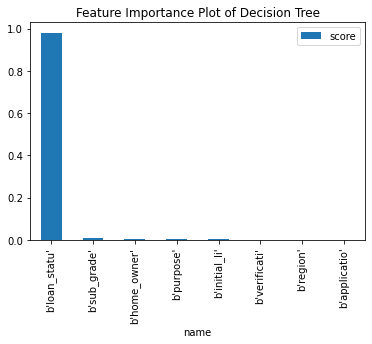

In [79]:
# gs_rf_efg.feature_import

feature_importance_forest = list(zip(X_efg_train.columns, gs_rf_efg.best_estimator_.feature_importances_))
dtype = [('feature', 'S10'), ('importance', 'float')]
feature_importance_forest = np.array(feature_importance_forest, dtype=dtype)
feature_sort_forest = np.sort(feature_importance_forest, order='importance')[::-1]
name, score = zip(*list(feature_sort_forest))
print(pd.DataFrame(feature_sort_forest[:20]))
pd.DataFrame({'name':name,'score':score})[:20].plot.bar(x='name', y='score')
plt.title('Feature Importance Plot of Decision Tree')

In [42]:
categorical_features = [feature for feature in model_df_efg.columns if model_df_efg[feature].dtypes == 'O']
categorical_features

['loan_status',
 'region',
 'application_type',
 'earliest_cr_line',
 'home_ownership',
 'sub_grade',
 'initial_list_status',
 'purpose',
 'verification_status']

In [22]:
# 3 years rf for grade G

model_df_g = model_df[model_df['grade']=='G']

# model_df_g = model_df[model_df['term']==' 36 months']
model_df_g_36 = model_df_g[(model_df_g['term'] == ' 36 months') & (model_df_g['year']<2016)]


model_df_g_36 = model_df_g_36[['loan_status','region','annual_inc','application_type','dti','earliest_cr_line',\
                               'fico_range_high','fico_range_low','funded_amnt','home_ownership','mort_acc','sub_grade',\
                               'installment','int_rate','open_acc','pub_rec','initial_list_status','purpose',\
                               'pub_rec_bankruptcies','total_acc','revol_bal','revol_util','delinq_amnt','verification_status',\
                               'delinq_2yrs','mths_since_last_delinq','mths_since_last_major_derog']]

# column transform with label encoding
le = LabelEncoder()
result = {}
for feature in model_df_g_36.drop('loan_status',axis=1).columns:
    result[feature] = pd.Series(le.fit_transform(model_df_g_36[feature]))
    
model_df_g_36_feature = pd.DataFrame(result)
model_df_g_36_target = model_df_g_36['loan_status'].astype(float)


# train test split
X_g_36_train, X_g_36_test, y_g_36_train, y_g_36_test = train_test_split(model_df_g_36_feature, model_df_g_36_target, test_size= 0.2)

rf_g_36 = RandomForestClassifier(class_weight="balanced",random_state=42)
params = {'n_estimators':range(20,101,20), 'max_depth':range(10,31,5), 'max_features':range(5,10),'max_samples':np.linspace(0.5,1,3),\
          'min_samples_leaf':range(1,5), 'min_samples_split':range(2,5)}
gs_rf_g_36 = GridSearchCV(rf_g_36, params, cv=5, iid=True, return_train_score=True)
%time gs_rf_g_36.fit(X_g_36_train,y_g_36_train)
rf_g_36.fit(X_g_36_train,y_g_36_train)

y_g_36_train_pred = rf_g_36.predict(X_g_36_train)
y_g_36_test_pred = rf_g_36.predict(X_g_36_test)
y_g_36_gs_train_pred = gs_rf_g_36.predict(X_g_36_train)
y_g_36_gs_test_pred = gs_rf_g_36.predict(X_g_36_test)
print('Original model')
print('*'*40)
print(rf_g_36.score(X_g_36_train,y_g_36_train))
print(rf_g_36.score(X_g_36_test,y_g_36_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_g_36_train,y_g_36_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_g_36_test,y_g_36_test_pred)}')
print('Grid Search model')
print('*'*40)
print(gs_rf_g_36.best_params_)
print('*'*40)
print(gs_rf_g_36.best_estimator_.score(X_g_36_train,y_g_36_train))
print(gs_rf_g_36.best_estimator_.score(X_g_36_test,y_g_36_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_g_36_train,y_g_36_gs_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_g_36_test,y_g_36_gs_test_pred)}')

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 344, in fit
    max_samples=self.max_samples
  File "D:\software\Anaconda\lib\site-packages\sklearn\ensemble\_forest.py", line 109, in _get_n_samples_bootstrap
    raise ValueError(msg.format(max_samples))
ValueError: `max_samples` must be in range (0, 1) but got value 1.0

  FitFailedWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Detail

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 29min 48s
Original model
****************************************
1.0
0.5985401459854015
****************************************
Train Set Confusion Matrix: 
 [[334   0]
 [  0 212]]
Test Set Confusion Matrix: 
 [[69 15]
 [40 13]]
Grid Search model
****************************************
{'max_depth': 15, 'max_features': 8, 'max_samples': 0.75, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 40}
****************************************
0.9926739926739927
0.583941605839416
****************************************
Train Set Confusion Matrix: 
 [[334   0]
 [  4 208]]
Test Set Confusion Matrix: 
 [[65 19]
 [38 15]]


In [38]:
# XGBoost Classifier

xgb_g_36 = XGBClassifier()
xgb_g_36.fit(X_g_36_train,y_g_36_train)

params = {'n_estimators':range(20,101,20), 'learning_rate':[1e-3,1e-2,1e-1,0.5,1],'max_depth':range(10,31,10),\
          'min_child_weight':range(2,10),'subsample':np.arange(0.5,1.1,0.1),'verbosity': [0]}
gs_xgb_g_36 = GridSearchCV(xgb_g_36, params, cv=5, iid=True, return_train_score=True)
%time gs_xgb_g_36.fit(X_g_36_train,y_g_36_train)

y_g_36_train_pred = xgb_g_36.predict(X_g_36_train)
y_g_36_test_pred = xgb_g_36.predict(X_g_36_test)
y_g_36_gs_train_pred = gs_xgb_g_36.predict(X_g_36_train)
y_g_36_gs_test_pred = gs_xgb_g_36.predict(X_g_36_test)

print(xgb_g_36.get_params)

print('Original model')
print('*'*40)
print(xgb_g_36.score(X_g_36_train,y_g_36_train))
print(xgb_g_36.score(X_g_36_test,y_g_36_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_g_36_train,y_g_36_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_g_36_test,y_g_36_test_pred)}')
print('Grid Search model')
print('*'*40)
print(gs_xgb_g_36.best_params_)
print('*'*40)
print(gs_xgb_g_36.best_estimator_.score(X_g_36_train,y_g_36_train))
print(gs_xgb_g_36.best_estimator_.score(X_g_36_test,y_g_36_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_g_36_train,y_g_36_gs_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_g_36_test,y_g_36_gs_test_pred)}')

[15:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


D:\software\Anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\software\Anaconda\lib\site-packages\xgboost\core.py", line 421, in inner_f
    return f(**kwargs)
  File "D:\software\Anaconda

Wall time: 16min 34s
<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)>
Original model
****************************************
1.0
0.5912408759124088
****************************************
Train Set Confusion Matrix: 
 [[334   0]
 [  0 212]]
Test Set Confusion Matrix: 
 [[59 25]
 [31 22]]
Grid Search model
****************************************
{'learning_rate': 0.01, 'max_depth': 10, 'min_child_weight': 6, 'n_estimators':

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


In [28]:
# 5 years rf for grade G

model_df_g = model_df[model_df['grade']=='G']

# model_df_g = model_df[model_df['term']==' 36 months']
model_df_g_60 = model_df_g[(model_df_g['term'] == ' 60 months') & (model_df_g['year']<2014)]


model_df_g_60 = model_df_g_60[['loan_status','region','annual_inc','application_type','dti','earliest_cr_line',\
                               'fico_range_high','fico_range_low','funded_amnt','home_ownership','mort_acc','sub_grade',\
                               'installment','int_rate','open_acc','pub_rec','initial_list_status','purpose',\
                               'pub_rec_bankruptcies','total_acc','revol_bal','revol_util','delinq_amnt','verification_status',\
                               'delinq_2yrs','mths_since_last_delinq','mths_since_last_major_derog']]

result = {}
for feature in model_df_g_60.drop('loan_status',axis=1).columns:
    result[feature] = pd.Series(le.fit_transform(model_df_g_60[feature]))
    
model_df_g_60_feature = pd.DataFrame(result)
model_df_g_60_target = model_df_g_60['loan_status'].astype(float)

# train test split
X_g_60_train, X_g_60_test, y_g_60_train, y_g_60_test = train_test_split(model_df_g_60_feature, model_df_g_60_target, test_size= 0.2)

rf_g_60 = RandomForestClassifier(class_weight="balanced")
params = {'n_estimators':range(20,101,20), 'max_depth':range(10,31,10), 'max_features':range(1,5), \
          'min_samples_leaf':range(1,5), 'min_samples_split':range(2,5)}
gs_rf_g_60 = GridSearchCV(rf_g_60, params, cv=5, iid=True, return_train_score=True)
%time gs_rf_g_60.fit(X_g_60_train,y_g_60_train)
rf_g_60.fit(X_g_60_train,y_g_60_train)


y_g_60_train_pred = rf_g_60.predict(X_g_60_train)
y_g_60_test_pred = rf_g_60.predict(X_g_60_test)
y_g_60_gs_train_pred = gs_rf_g_60.predict(X_g_60_train)
y_g_60_gs_test_pred = gs_rf_g_60.predict(X_g_60_test)
print('Original model')
print('*'*40)
print(rf_g_60.score(X_g_60_train,y_g_60_train))
print(rf_g_60.score(X_g_60_test,y_g_60_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_g_60_train,y_g_60_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_g_60_test,y_g_60_test_pred)}')
print('Grid Search model')
print('*'*40)
print(gs_rf_g_60.best_params_)
print('*'*40)
print(gs_rf_g_60.best_estimator_.score(X_g_60_train,y_g_60_train))
print(gs_rf_g_60.best_estimator_.score(X_g_60_test,y_g_60_test))
print('*'*40)
print(f'Train Set Confusion Matrix: \n {confusion_matrix(y_g_60_train,y_g_60_gs_train_pred)}')
print(f'Test Set Confusion Matrix: \n {confusion_matrix(y_g_60_test,y_g_60_gs_test_pred)}')

D:\software\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:849: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Wall time: 8min 29s
Original model
****************************************
1.0
0.6123188405797102
****************************************
Train Set Confusion Matrix: 
 [[699   0]
 [  0 402]]
Test Set Confusion Matrix: 
 [[158  14]
 [ 93  11]]
Grid Search model
****************************************
{'max_depth': 30, 'max_features': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
****************************************
0.9990917347865577
0.5942028985507246
****************************************
Train Set Confusion Matrix: 
 [[699   0]
 [  1 401]]
Test Set Confusion Matrix: 
 [[146  26]
 [ 86  18]]
